In [1]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import os, glob, pickle
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Reshape
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import soundfile as sf
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import soundfile
seed=7
np.random.seed(seed)

2024-07-19 17:18:29.630261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 17:18:29.630361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 17:18:29.755812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "/kaggle/input/ravdess-emotional-speech-audio/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:10]

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10']

In [4]:
emotion_map = {
  "01": "neutral",
  "02": "calm",
  "03": "happy",
  "04": "sad",
  "05": "angry",
  "06": "fearful",
  "07": "disgust",
  "08": "surprised"
}

# Initialize a list to store rows of the DataFrame
data = []

# Loop through each directory and each file within the directory
for directory in actor_folders:
    directory_path = os.path.join(audio, directory)
    if os.path.isdir(directory_path):
        for filename in os.listdir(directory_path):
            if filename.endswith(".wav"):
                # Extract the emotion abbreviation from the filename
                emo_abb = filename.split('-')[2]
                # print(emo_abb)
                # Get the emotion name from the emotion_map dictionary
                emotion = emotion_map.get(emo_abb, 'Unknown')
                # Full path to the audio file
                file_path = os.path.join(directory_path, filename)
                # Append the emotion and file path to the data list
                data.append([emotion, file_path])

    #         break
    # break

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['Emotions', 'path'])

In [5]:
# EXPORT TO CSV
df.to_csv('./audio.csv')

In [6]:
# Read Data
data = pd.read_csv('./audio.csv')
data.head(5)
data.shape

(1440, 3)

In [7]:
data_path = pd.concat([df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               path
0     calm  /kaggle/input/ravdess-emotional-speech-audio/A...
1  neutral  /kaggle/input/ravdess-emotional-speech-audio/A...
2      sad  /kaggle/input/ravdess-emotional-speech-audio/A...
3     calm  /kaggle/input/ravdess-emotional-speech-audio/A...
4     calm  /kaggle/input/ravdess-emotional-speech-audio/A...

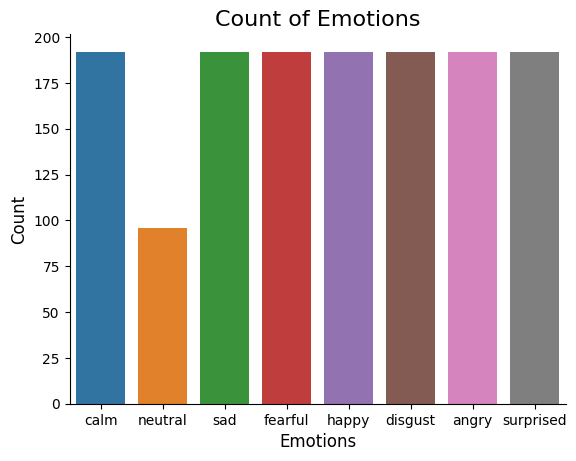

In [8]:
from sklearn.preprocessing import LabelEncoder

# Assuming data_path is a DataFrame with an 'emotion' column (containing text labels)

# Create a label encoder
le = LabelEncoder()

# Encode the emotion labels
data_path['emotion_encoded'] = le.fit_transform(data_path['Emotions'])

# Create the countplot using the encoded emotion column
plt.title('Count of Emotions', size=16)
sns.countplot(x="Emotions", data=data_path)  # Use "x" for the category variable
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

# Remove top and right spines, keep bottom and left for reference
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

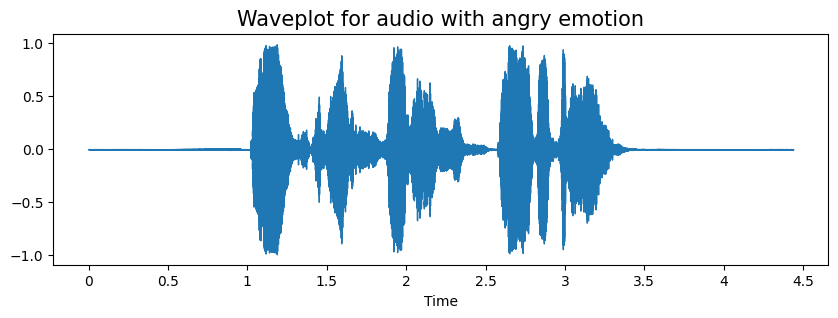

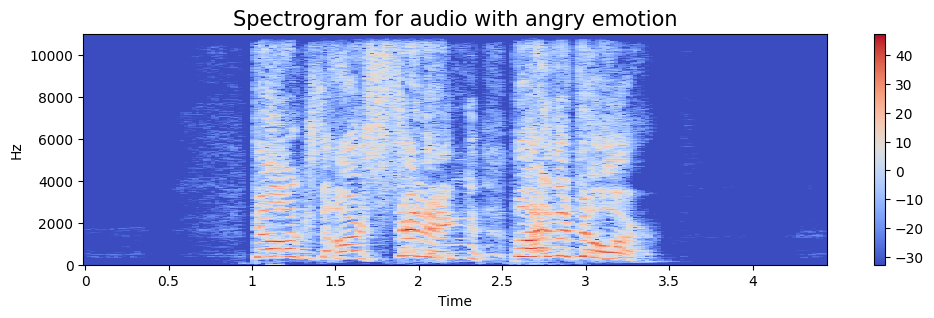

In [10]:
emotion='angry'
path = np.array(data_path.path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def noise2(data):
    noise_amp = 0.025*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data,sr=sampling_rate,n_steps=pitch_factor)

def pitch2(data, sampling_rate, pitch_factor=0.6):
    return librosa.effects.pitch_shift(y=data,sr=sampling_rate,n_steps=pitch_factor)
# taking any example and checking for techniques.
path = np.array(data_path.path)[1]
data, sample_rate = librosa.load(path)

In [12]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
       
    return result

In [13]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array([])
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with noise2
    noise_data2 = noise2(data)
    res3 = extract_features(noise_data2)
    result = np.vstack((result, res3)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    # data with stretching and pitching
    new_data1 = stretch(data)
    data_stretch_pitch = pitch2(new_data1, sample_rate)
    res4 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res4)) # stacking vertically
    return result

In [14]:
X, Y = [], []
for path, emotion in zip(df.path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [15]:
len(X), len(Y), data_path.path.shape

(7200, 7200, (1440,))

In [16]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.277900  0.602604  0.667741  0.690958  0.711157  0.668959  0.606182   
1  0.234918  0.630396  0.682588  0.704155  0.722267  0.725617  0.663593   
2  0.271719  0.684519  0.733242  0.752150  0.772196  0.748595  0.655196   
3  0.158160  0.588082  0.678833  0.712739  0.680749  0.635305  0.596975   
4  0.164290  0.611256  0.623630  0.730878  0.714912  0.681189  0.624596   

          7         8         9  ...           146       147       148  \
0  0.608332  0.640324  0.688707  ...  8.842155e-06  0.000012  0.000028   
1  0.603041  0.624497  0.681686  ...  9.896957e-06  0.000013  0.000028   
2  0.615734  0.646163  0.732850  ...  5.282248e-05  0.000052  0.000068   
3  0.607184  0.616592  0.650752  ...  7.591914e-07  0.000001  0.000002   
4  0.598159  0.619674  0.629439  ...  7.311822e-07  0.000001  0.000003   

        149       150       151       152       153           154  labels  
0  0.000034  0.000036  0.000036  0.000042  0.000024  2.138941e-06    calm  
1  0.000034  0.000038  0.000037  0.000043  0.000025  3.329885e-06    calm  
2  0.000075  0.000077  0.000077  0.000085  0.000063  4.486996e-05    calm  
3  0.000004  0.000006  0.000006  0.000006  0.000003  3.107127e-07    calm  
4  0.000004  0.000005  0.000005  0.000006  0.000004  3.514971e-07    calm  

[5 rows x 156 columns]

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5760, 155), (5760,), (1440, 155), (1440,))

In [18]:
# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

In [19]:
# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [20]:
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
(5760, 155, 1)
(1440, 155, 1)


In [21]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=4, shuffle=True)
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

(7200, 8)

In [22]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(64, kernel_size=(5),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(8, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',   save_weights_only=True)
  model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,025,288 (7.73 MB)

 Trainable params: 2,022,856 (7.72 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000
  7/169 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1189 - loss: 5.3596

I0000 00:00:1721410398.241389      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1434 - loss: 4.7854
Epoch 1: val_accuracy improved from -inf to 0.16528, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 154ms/step - accuracy: 0.1435 - loss: 4.7825 - val_accuracy: 0.1653 - val_loss: 3.4354
Epoch 2/1000
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1782 - loss: 3.1552
Epoch 2: val_accuracy improved from 0.16528 to 0.17569, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1784 - loss: 3.1479 - val_accuracy: 0.1757 - val_loss: 2.4908
Epoch 3/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2085 - loss: 2.3678
Epoch 3: val_accuracy improved from 0.17569 to 0.19792, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2085 - loss: 2.3672 - val_accuracy: 0.1979 - val_loss: 2.2027
Epoch 4/1000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2255 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,025,288 (7.73 MB)

 Trainable params: 2,022,856 (7.72 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1517 - loss: 4.7586
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.1517 - loss: 4.7555 - val_accuracy: 0.1667 - val_loss: 3.3446
Epoch 2/1000
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1994 - loss: 3.0692
Epoch 2: val_accuracy improved from 0.16667 to 0.19306, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1995 - loss: 3.0617 - val_accuracy: 0.1931 - val_loss: 2.4492
Epoch 3/1000
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2241 - loss: 2.3155
Epoch 3: val_accuracy improved from 0.19306 to 0.23681, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2243 - loss: 2.3130 - val_

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,025,288 (7.73 MB)

 Trainable params: 2,022,856 (7.72 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1487 - loss: 4.7957
Epoch 1: val_accuracy improved from -inf to 0.16389, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - accuracy: 0.1488 - loss: 4.7926 - val_accuracy: 0.1639 - val_loss: 3.3695
Epoch 2/1000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1959 - loss: 3.0643
Epoch 2: val_accuracy improved from 0.16389 to 0.16667, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1960 - loss: 3.0614 - val_accuracy: 0.1667 - val_loss: 2.5017
Epoch 3/1000
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2134 - loss: 2.2983
Epoch 3: val_accuracy improved from 0.16667 to 0.20764, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2136 - loss: 2.2960 - val_

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,025,288 (7.73 MB)

 Trainable params: 2,022,856 (7.72 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.1527 - loss: 4.6848
Epoch 1: val_accuracy improved from -inf to 0.16181, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.1528 - loss: 4.6818 - val_accuracy: 0.1618 - val_loss: 3.2618
Epoch 2/1000
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1925 - loss: 2.9708
Epoch 2: val_accuracy improved from 0.16181 to 0.20625, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1925 - loss: 2.9651 - val_accuracy: 0.2062 - val_loss: 2.3827
Epoch 3/1000
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2152 - loss: 2.2254
Epoch 3: val_accuracy improved from 0.20625 to 0.27708, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2152 - loss: 2.2240 - val_

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.1630
Loss of the model is -  0.192228302359581
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.1630
Accuracy of the model is -  97.98611402511597 %
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


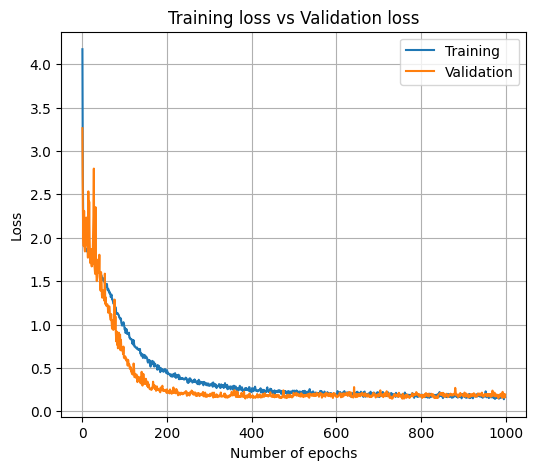

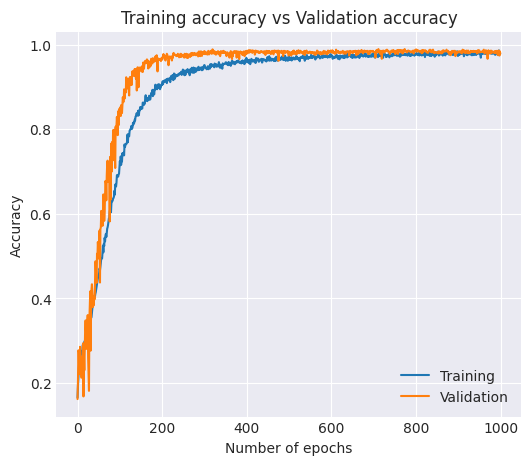

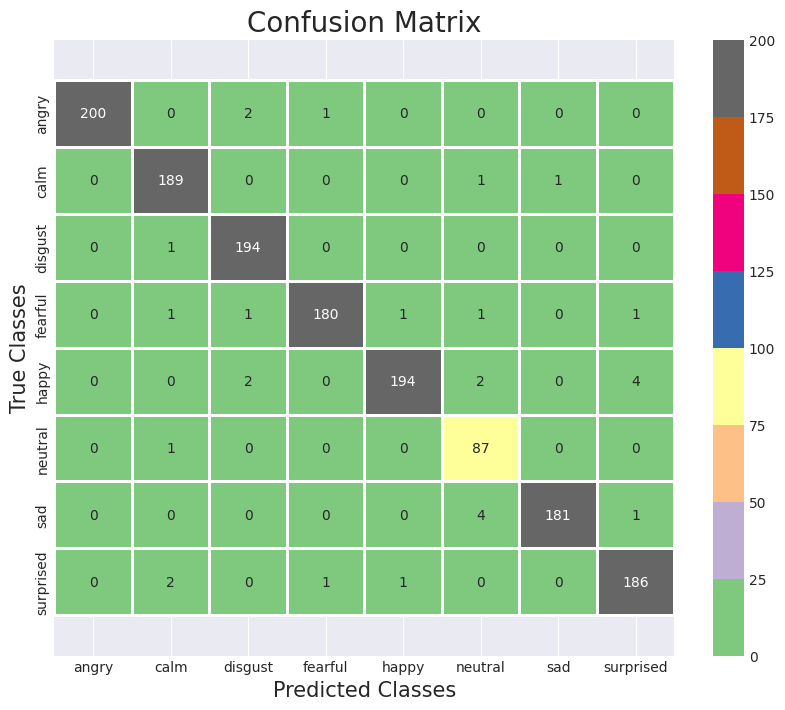

In [23]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (10, 8))
plt.rcParams['figure.dpi'] = 200 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-CHROMA.png')
plt.show()

In [24]:
#New

In [25]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',   save_weights_only=True)
model_history=model.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,074,440 (7.91 MB)

 Trainable params: 2,072,008 (7.90 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/1000
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1803 - loss: 4.4266
Epoch 1: val_accuracy improved from -inf to 0.19931, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.1805 - loss: 4.4170 - val_accuracy: 0.1993 - val_loss: 2.8955
Epoch 2/1000
176/180 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2383 - loss: 2.5491
Epoch 2: val_accuracy improved from 0.19931 to 0.20000, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2383 - loss: 2.5440 - val_accuracy: 0.2000 - val_loss: 2.2573
Epoch 3/1000
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2674 - loss: 2.0292
Epoch 3: val_accuracy improved from 0.20000 to 0.28750, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2674 - loss: 2.0289 - val_accuracy: 0.2875 - val_loss: 1.8542
Epoch 4/1000
177/180 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accura

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9356 - loss: 0.3817
Loss of the model is -  0.3690837323665619
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9356 - loss: 0.3817
Accuracy of the model is -  94.37500238418579 %
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


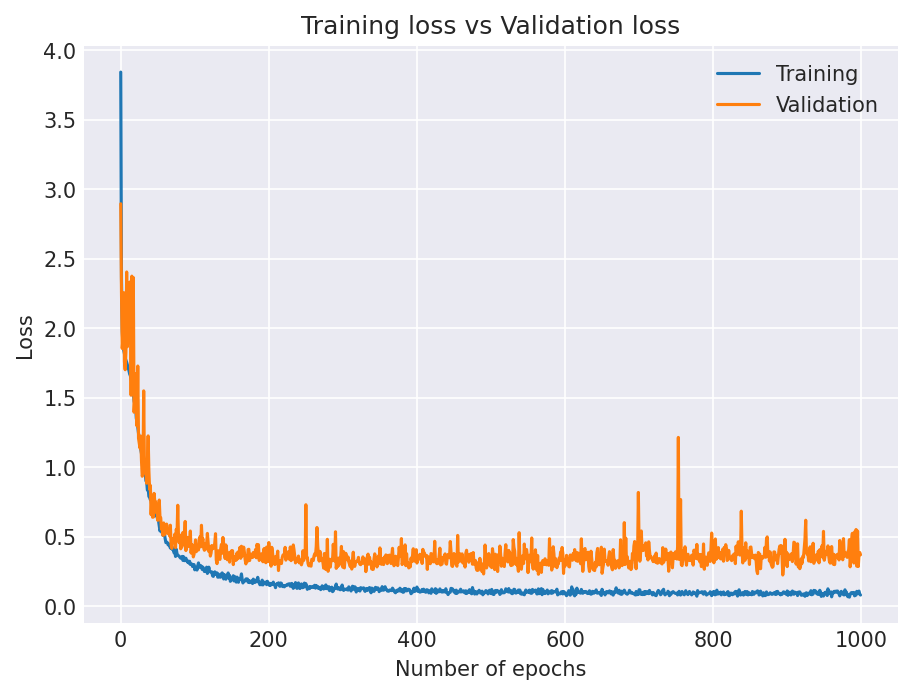

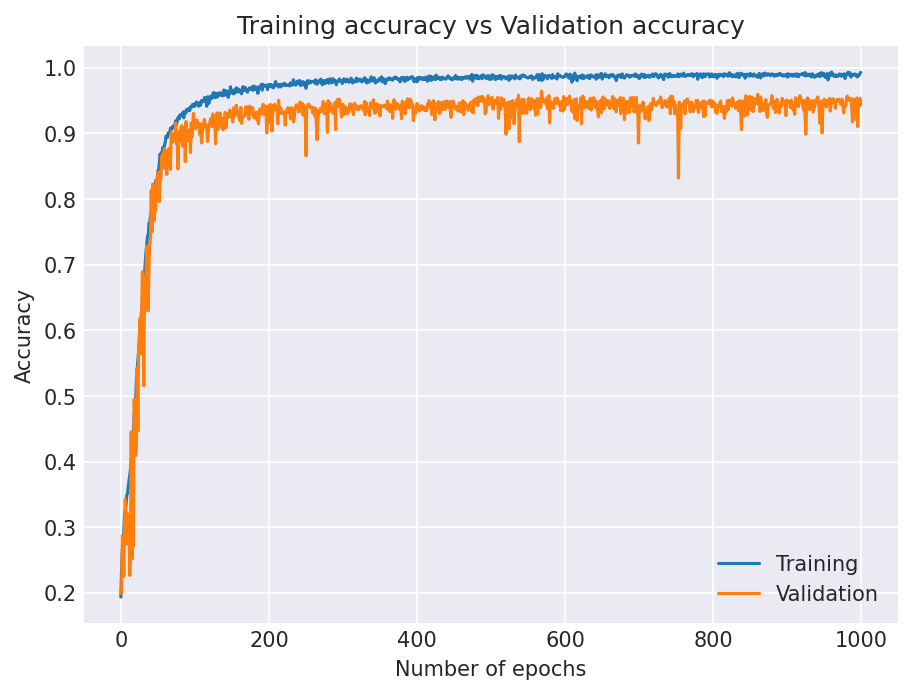

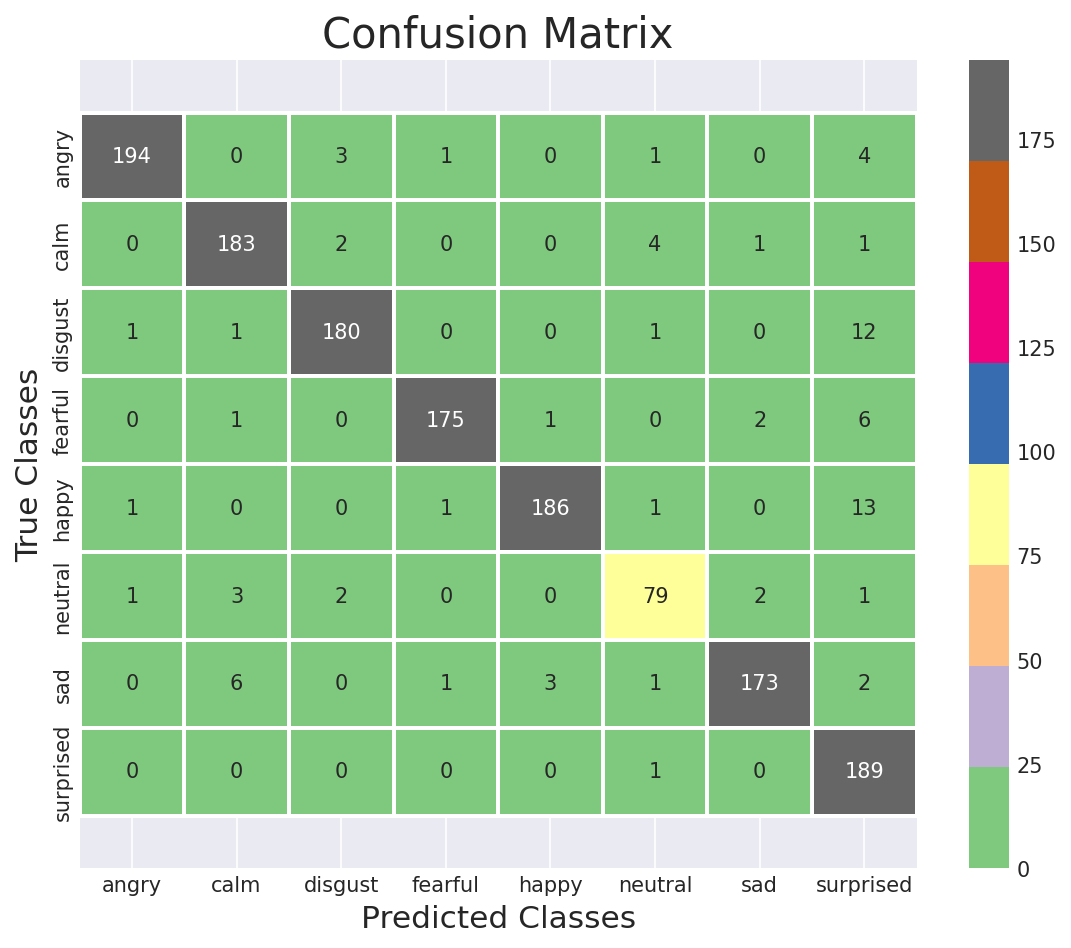

              precision    recall  f1-score   support

       angry       0.98      0.96      0.97       203
        calm       0.94      0.96      0.95       191
     disgust       0.96      0.92      0.94       195
        fear       0.98      0.95      0.96       185
       happy       0.98      0.92      0.95       202
     neutral       0.90      0.90      0.90        88
         sad       0.97      0.93      0.95       186
    surprise       0.83      0.99      0.90       190

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.95      0.94      0.94      1440



In [26]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

In [27]:
#ENSEMBLE

In [28]:
#MODEL1
model1 = tf.keras.Sequential()
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(8, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model1.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
model_history=model1.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model1.save('saved_models/model1-ravdess.weights.h5')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,074,440 (7.91 MB)

 Trainable params: 2,072,008 (7.90 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/1000
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1627 - loss: 4.4288
Epoch 1: val_accuracy improved from -inf to 0.22708, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.1629 - loss: 4.4219 - val_accuracy: 0.2271 - val_loss: 2.7431
Epoch 2/1000
176/180 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2280 - loss: 2.4923
Epoch 2: val_accuracy did not improve from 0.22708
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2282 - loss: 2.4873 - val_accuracy: 0.2257 - val_loss: 2.0886
Epoch 3/1000
176/180 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2422 - loss: 1.9947
Epoch 3: val_accuracy improved from 0.22708 to 0.23472, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2424 - loss: 1.9937 - val_accuracy: 0.2347 - val_loss: 2.1063
Epoch 4/1000
176/180 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2447 - loss: 1.9032
Epoch 4: val_accuracy improve

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9515 - loss: 0.3820
Loss of the model is -  0.4047856628894806
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9515 - loss: 0.3820
Accuracy of the model is -  94.86111402511597 %
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


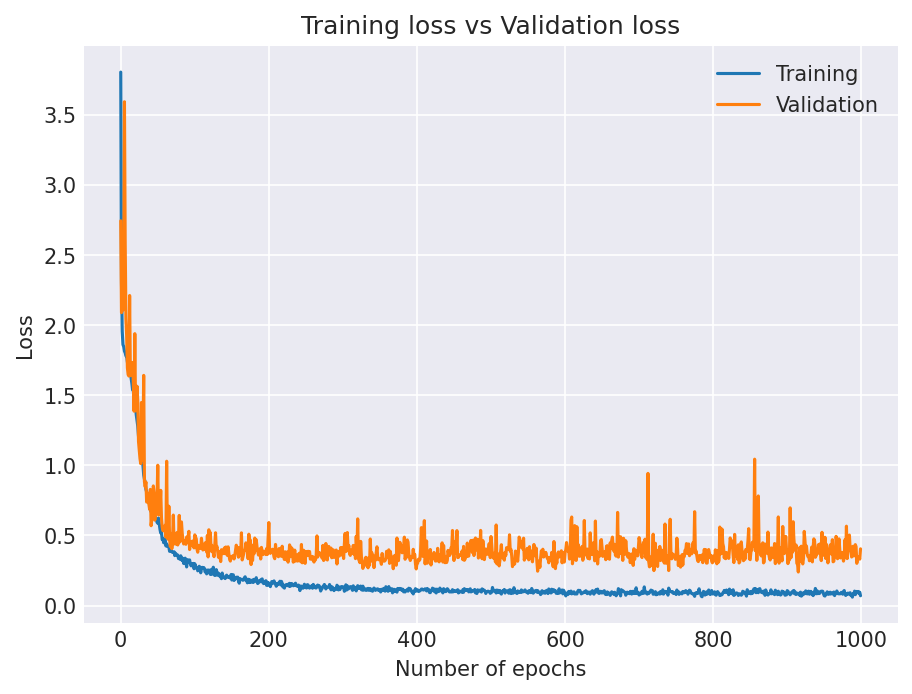

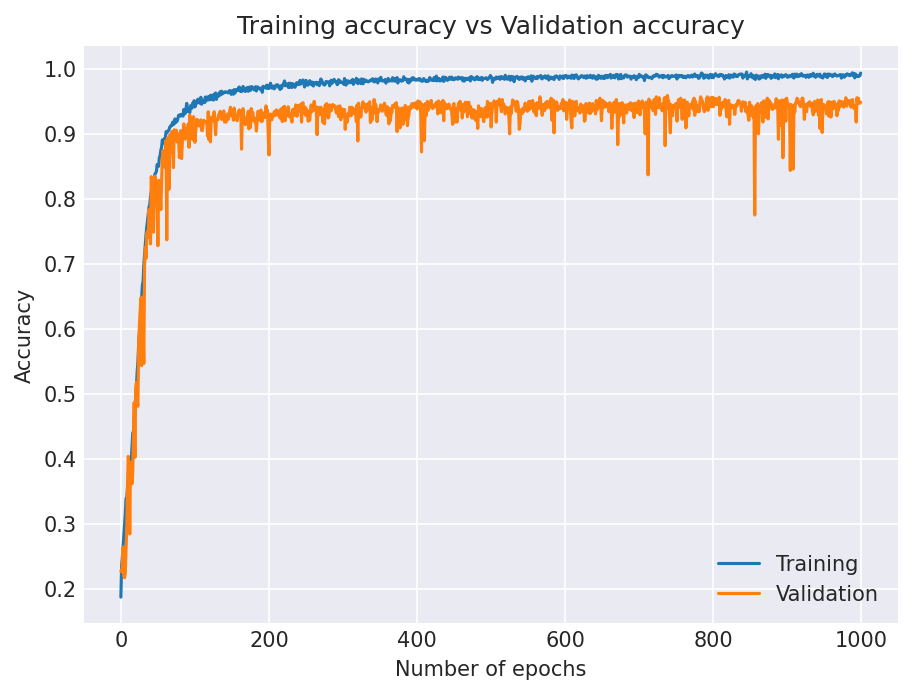

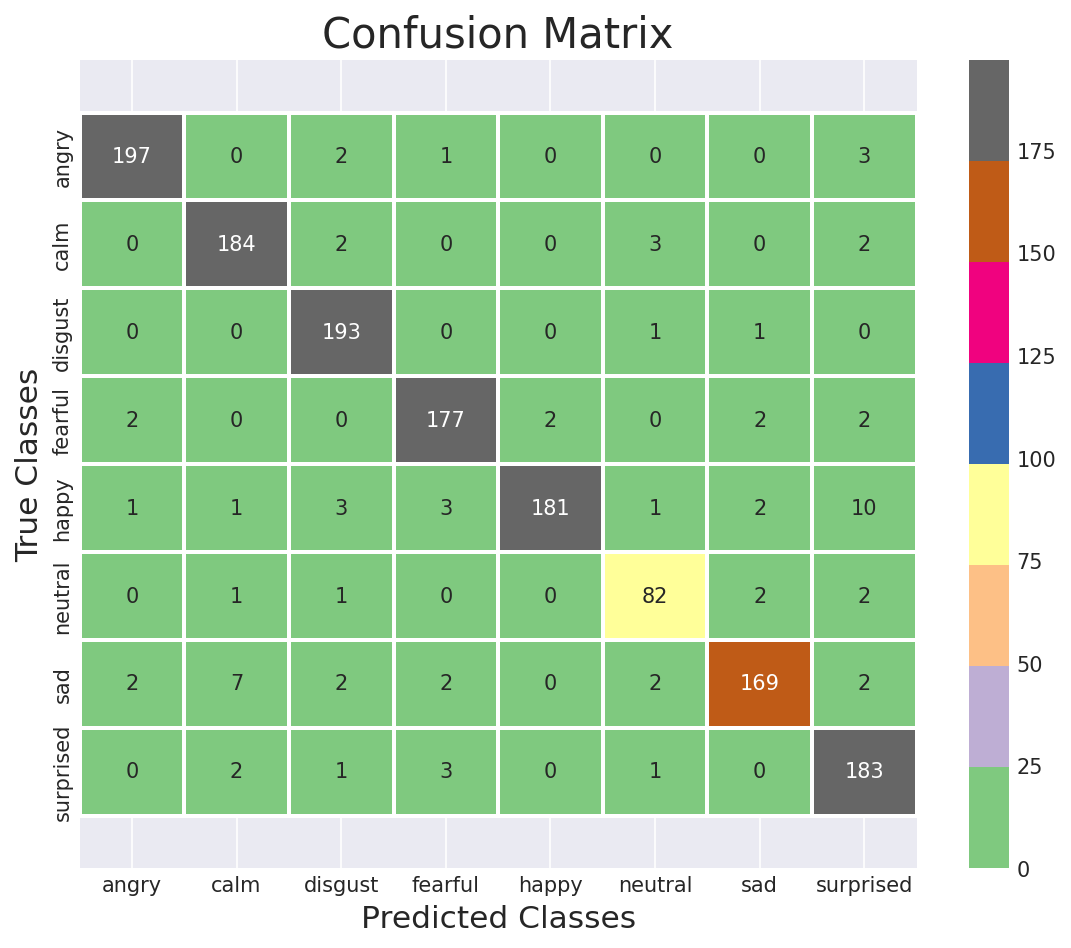

              precision    recall  f1-score   support

       angry       0.98      0.97      0.97       203
        calm       0.94      0.96      0.95       191
     disgust       0.95      0.99      0.97       195
        fear       0.95      0.96      0.95       185
       happy       0.99      0.90      0.94       202
     neutral       0.91      0.93      0.92        88
         sad       0.96      0.91      0.93       186
    surprise       0.90      0.96      0.93       190

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440



In [29]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss'] 
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model1.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model1.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model1.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('ravdess-model1.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

In [30]:
#MODEL2
model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.GRU(512))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(8, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model2.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',   save_weights_only=True)
model_history=model2.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model2.save('saved_models/model2-ravdess.weights.h5')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_45 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_46 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_54 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,191,624 (12.18 MB)

 Trainable params: 3,189,192 (12.17 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/1000
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1789 - loss: 3.7208
Epoch 1: val_accuracy improved from -inf to 0.18056, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.1795 - loss: 3.7078 - val_accuracy: 0.1806 - val_loss: 2.5867
Epoch 2/1000
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2447 - loss: 1.9660
Epoch 2: val_accuracy improved from 0.18056 to 0.19583, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.2448 - loss: 1.9654 - val_accuracy: 0.1958 - val_loss: 2.6678
Epoch 3/1000
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2754 - loss: 1.8698
Epoch 3: val_accuracy improved from 0.19583 to 0.26944, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.2756 - loss: 1.8696 - val_accuracy: 0.2694 - val_loss: 1.9472
Epoch 4/1000
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accura

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9391 - loss: 0.4112
Loss of the model is -  0.37775367498397827
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9391 - loss: 0.4112
Accuracy of the model is -  94.30555701255798 %
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


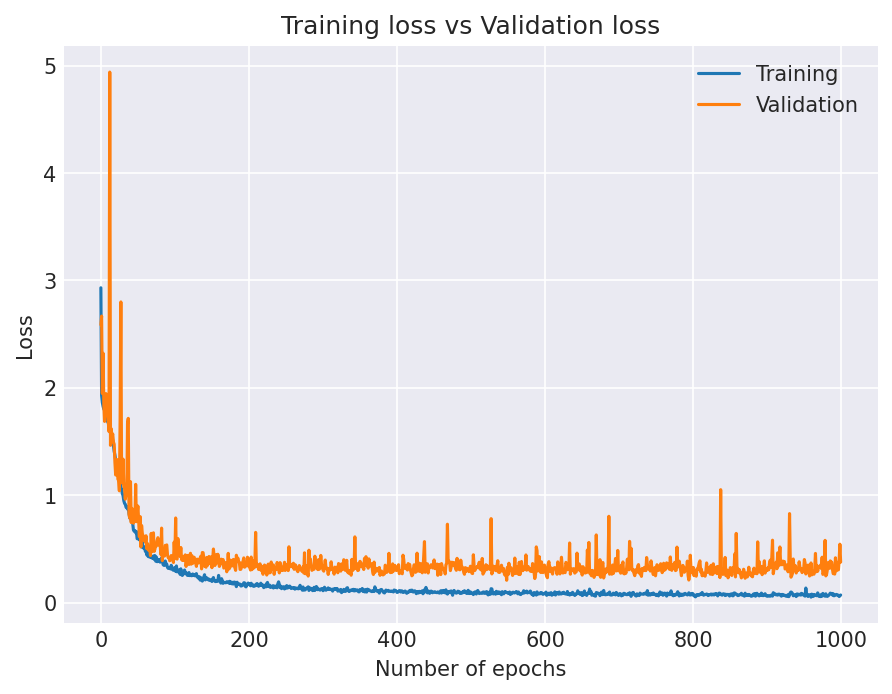

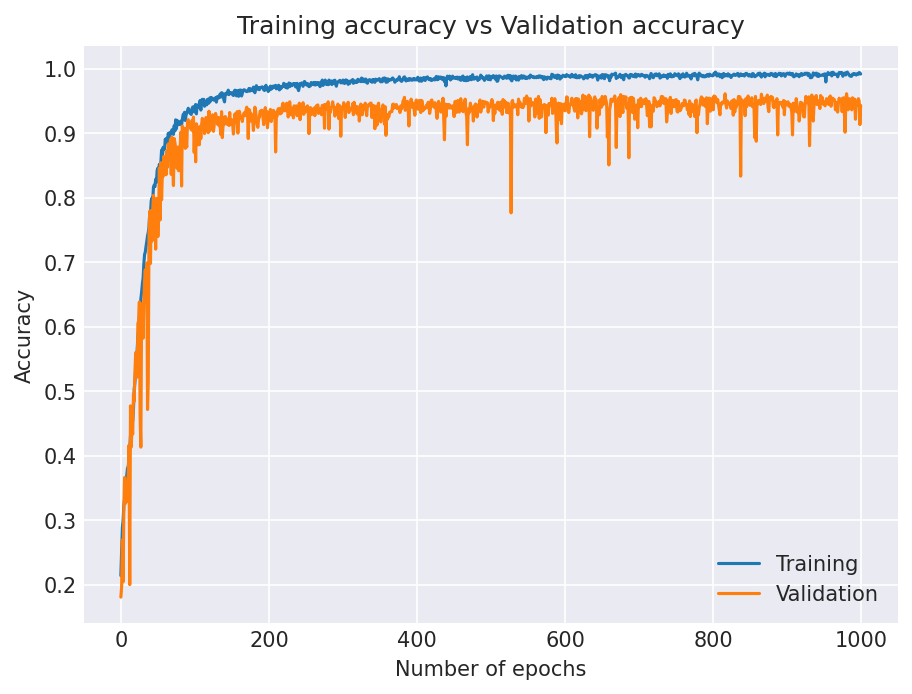

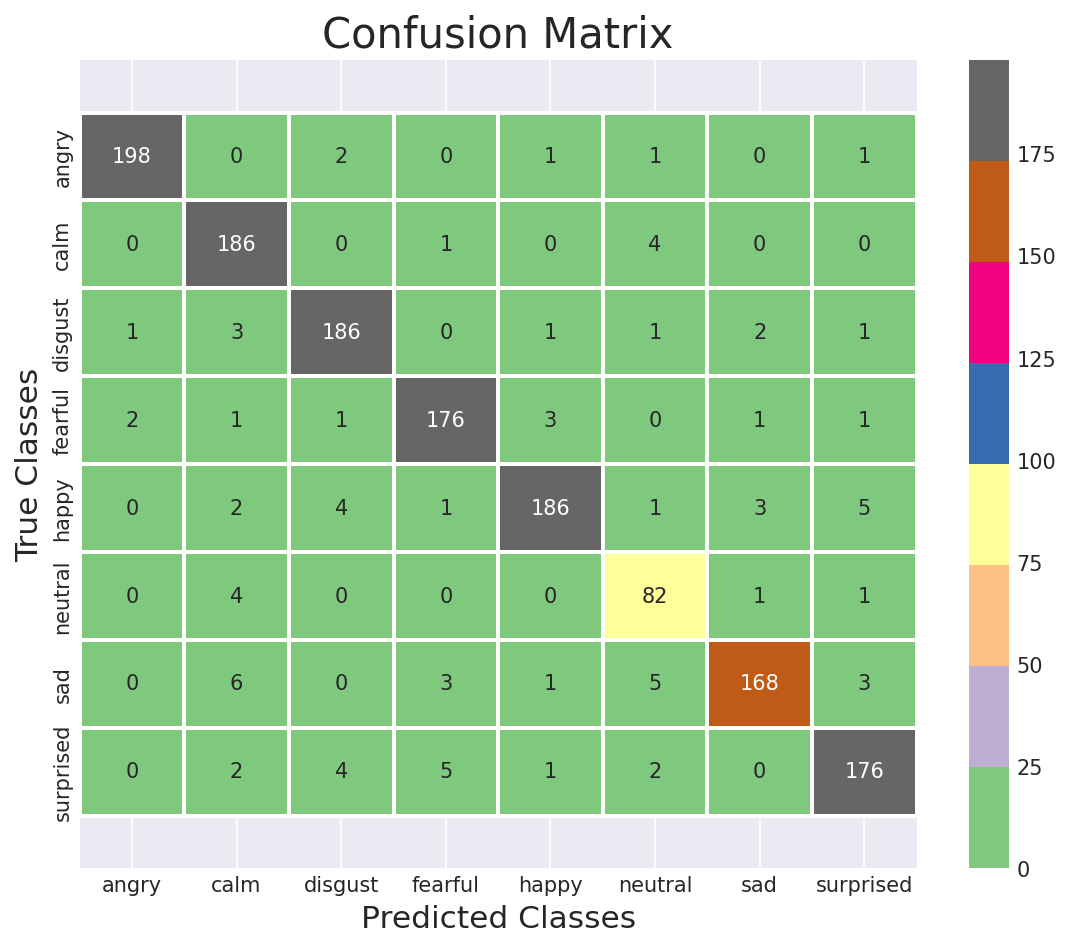

              precision    recall  f1-score   support

       angry       0.99      0.98      0.98       203
        calm       0.91      0.97      0.94       191
     disgust       0.94      0.95      0.95       195
        fear       0.95      0.95      0.95       185
       happy       0.96      0.92      0.94       202
     neutral       0.85      0.93      0.89        88
         sad       0.96      0.90      0.93       186
    surprise       0.94      0.93      0.93       190

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



In [31]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))  
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model2.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('ravdess-model1.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

In [32]:
#MODEL3
model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(layers.MaxPooling1D(pool_size=(2))) 
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization()) 
model3.add(layers.Dropout(0.25))  
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.LSTM(512))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(8, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model3.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',   save_weights_only=True)
model_history=model3.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model3.save('saved_models/model3-ravdess.weights.h5')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_56 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_49 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_58 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_51 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_60 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_52 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_61 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_53 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_62 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,485,512 (13.30 MB)

 Trainable params: 3,483,080 (13.29 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/1000
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1933 - loss: 3.3099
Epoch 1: val_accuracy improved from -inf to 0.14097, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.1938 - loss: 3.2971 - val_accuracy: 0.1410 - val_loss: 2.1764
Epoch 2/1000
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2478 - loss: 1.8894
Epoch 2: val_accuracy improved from 0.14097 to 0.21944, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2480 - loss: 1.8892 - val_accuracy: 0.2194 - val_loss: 2.7574
Epoch 3/1000
178/180 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2857 - loss: 1.8476
Epoch 3: val_accuracy improved from 0.21944 to 0.22639, saving model to SER_best_initial_model.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2856 - loss: 1.8475 - val_accuracy: 0.2264 - val_loss: 2.5099
Epoch 4/1000
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accura

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9456 - loss: 0.3377
Loss of the model is -  0.37476810812950134
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9456 - loss: 0.3377
Accuracy of the model is -  94.16666626930237 %
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


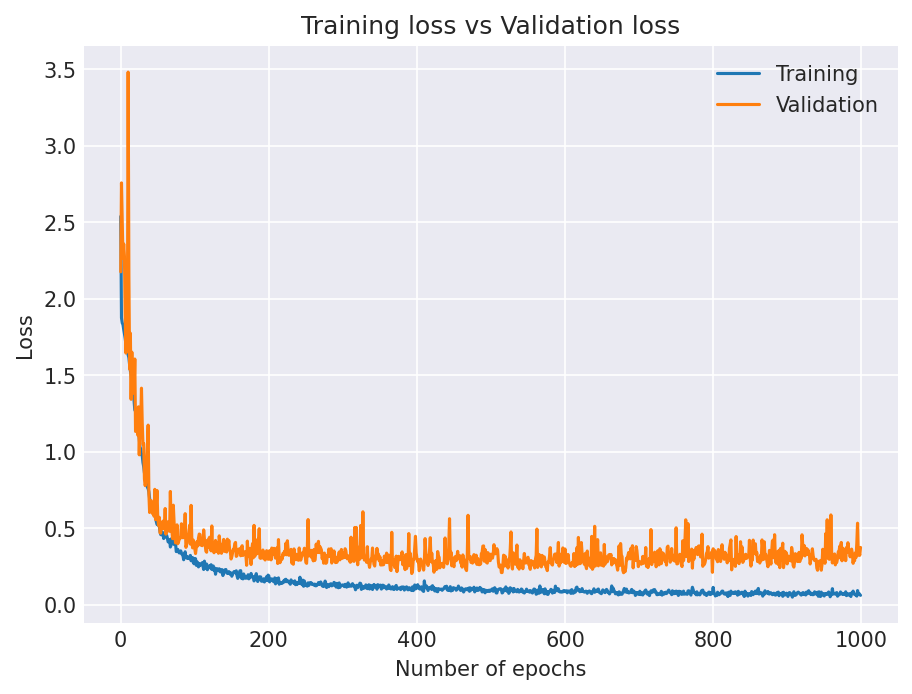

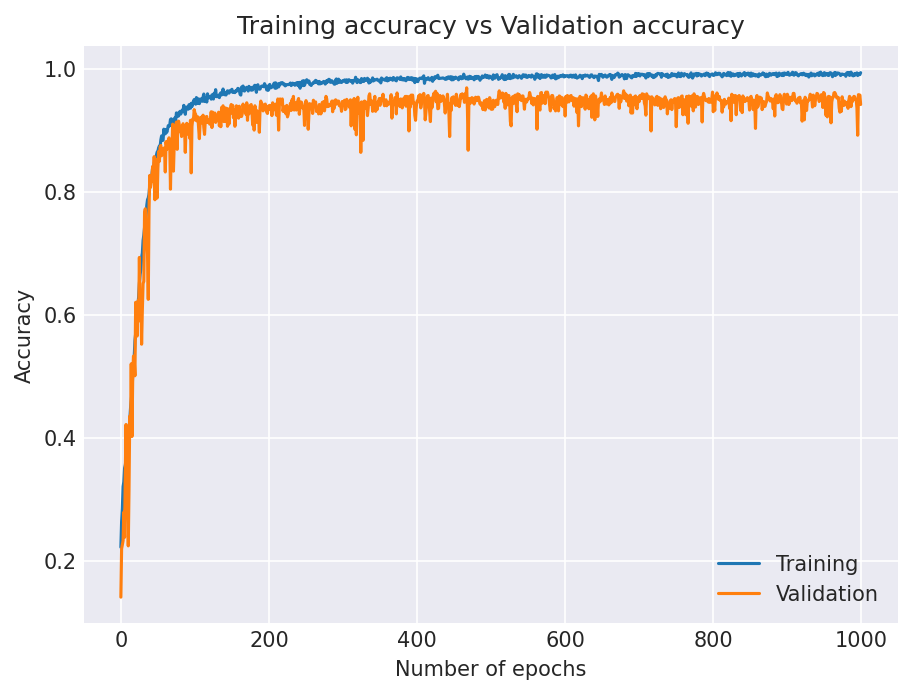

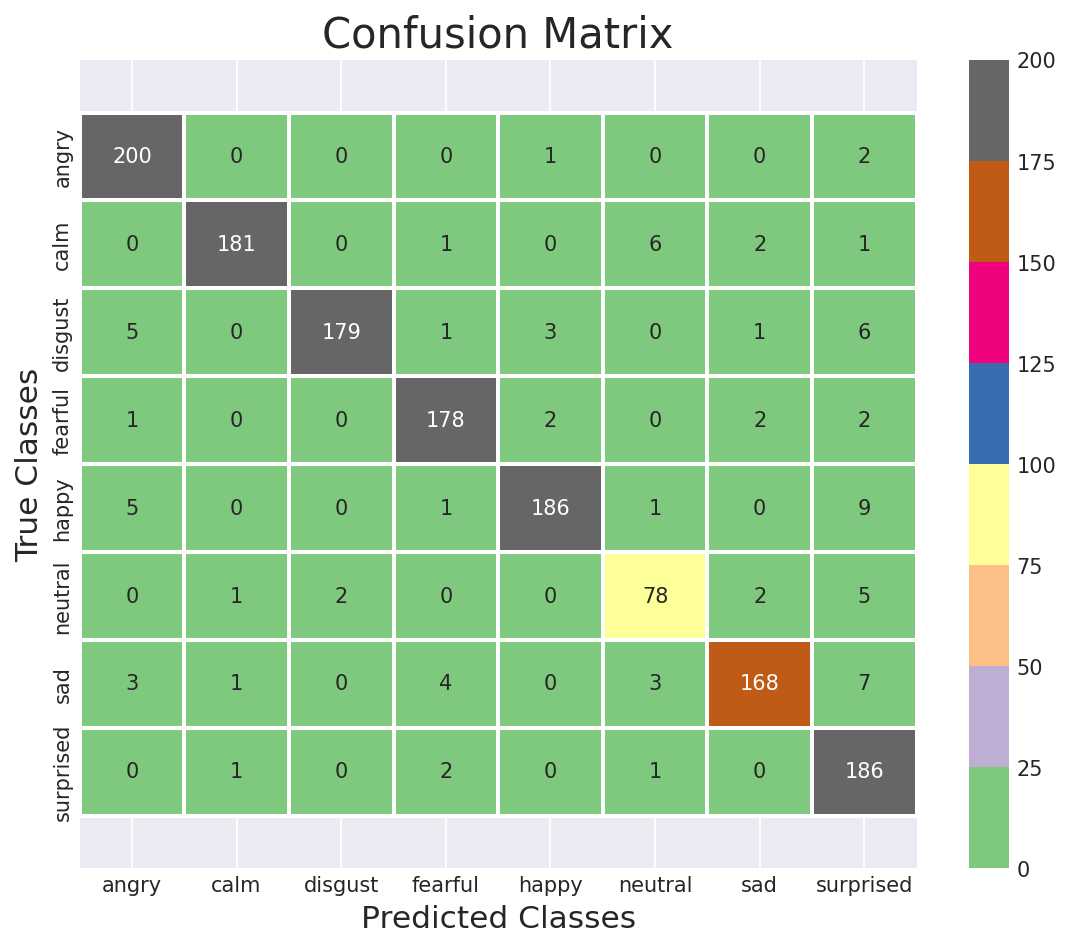

              precision    recall  f1-score   support

       angry       0.93      0.99      0.96       203
        calm       0.98      0.95      0.97       191
     disgust       0.99      0.92      0.95       195
        fear       0.95      0.96      0.96       185
       happy       0.97      0.92      0.94       202
     neutral       0.88      0.89      0.88        88
         sad       0.96      0.90      0.93       186
    surprise       0.85      0.98      0.91       190

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



In [33]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy'] 
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model3.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model3.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model3.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('ravdess-model1.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy Score for model1 =  0.9486111111111111
Accuracy Score for model2 =  0.9430555555555555
Accuracy Score for model3 =  0.9416666666666667
Accuracy Score for average ensemble =  0.9618055555555556
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Weighted average method
Accuracy Score for model1 =  0.9486111111111111
Accuracy Score for model2 =  0.9430555555555555
Accuracy Score for model3 =  0.9416666666666667
Accuracy Score for average ensemble =  0.9618055555555556
Accuracy Score for weighted average ensemble =  0.9590277777777778
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Max accuracy of  96.18055555555556  o

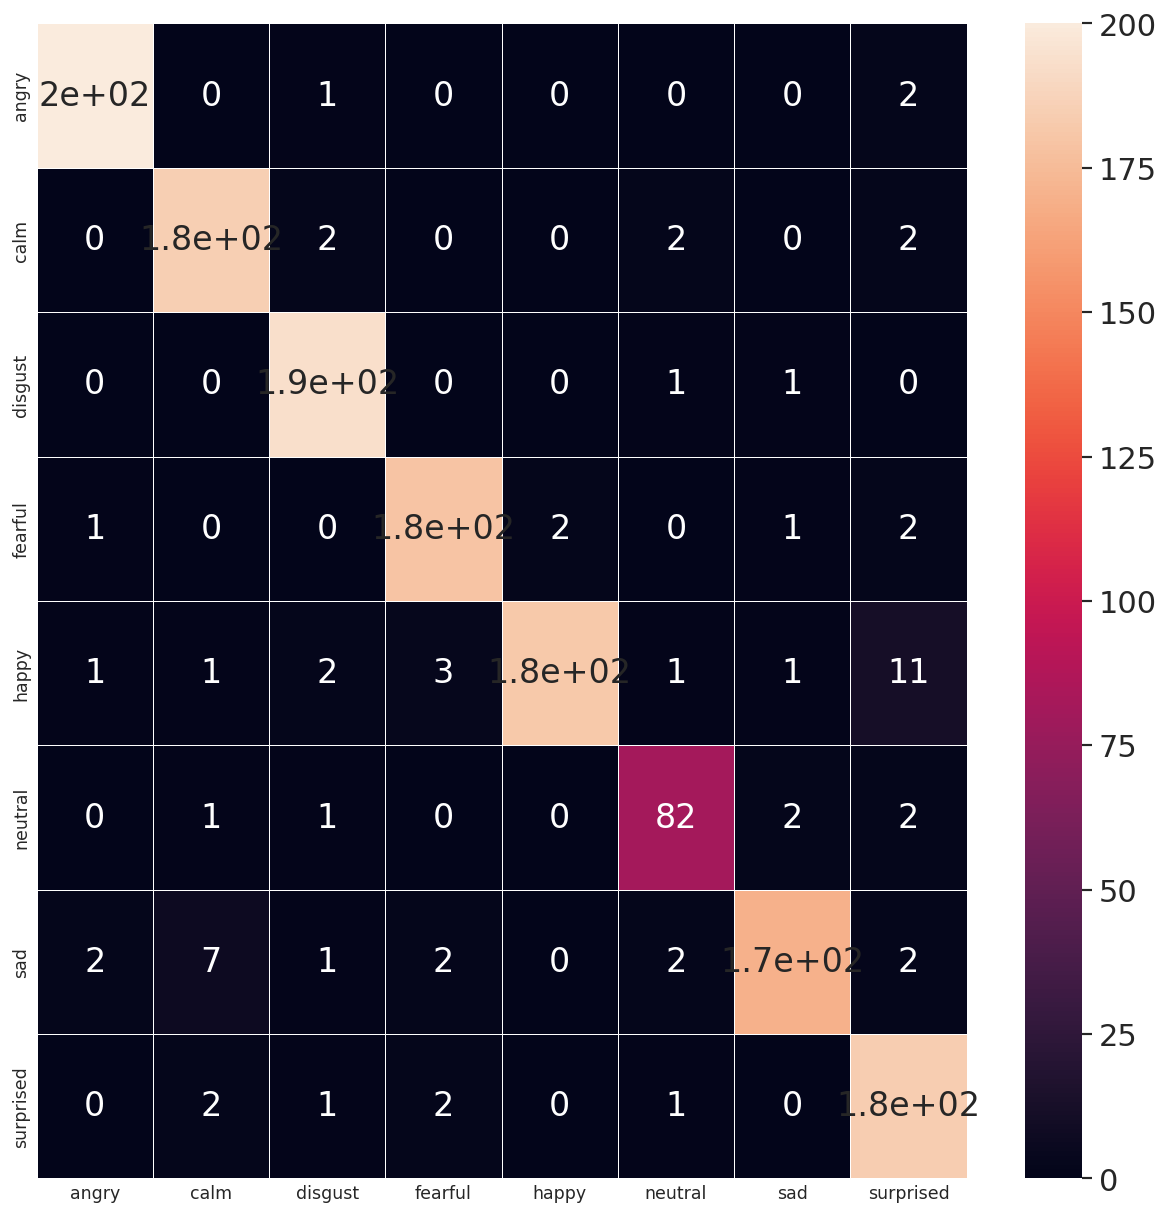

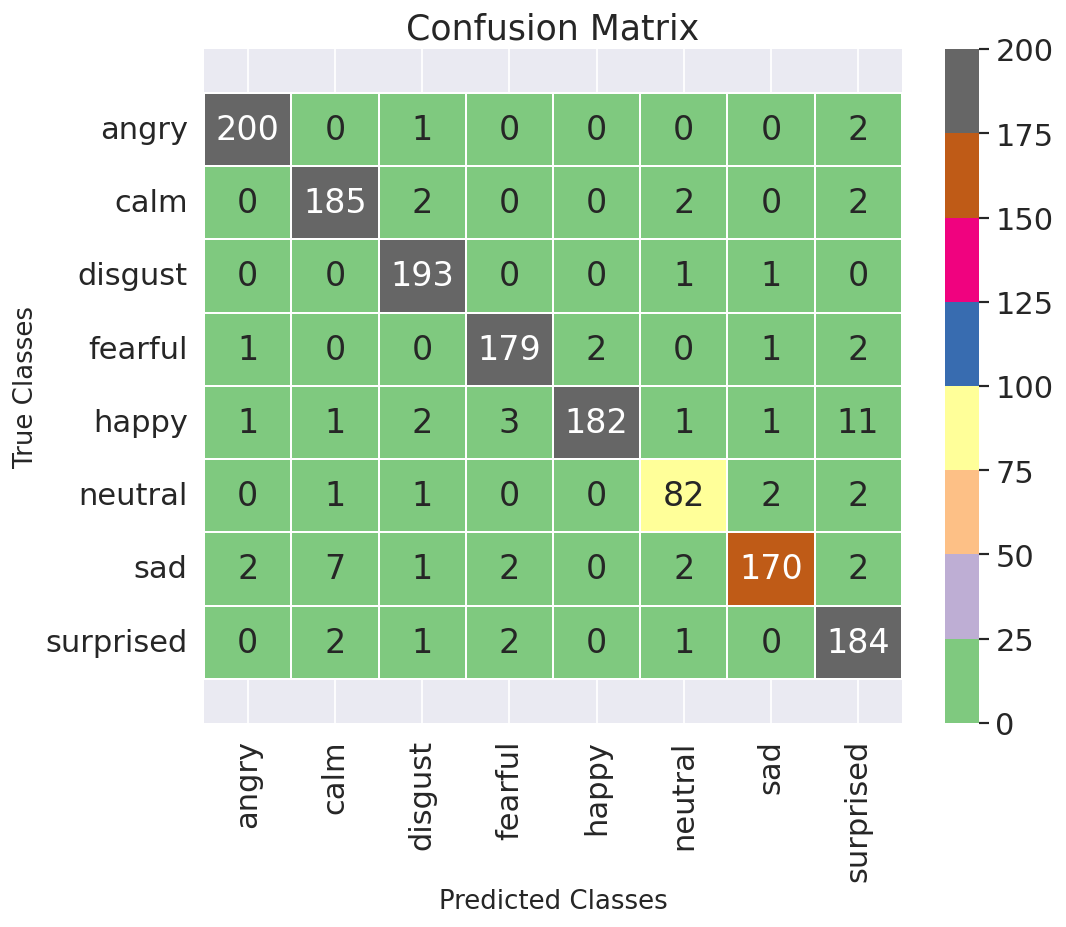

In [34]:
import random
#########################################################################
### Model average / sum Ensemble
# Simple sum of all outputs / predictions and argmax across all classes
########
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('saved_models/model1-ravdess.weights.h5')
model2 = load_model('saved_models/model2-ravdess.weights.h5')
model3 = load_model('saved_models/model3-ravdess.weights.h5')

models = [model1, model2, model3]

preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = np.argmax(model1.predict(x_test), axis=1)
prediction2 = np.argmax(model2.predict(x_test), axis=1)
prediction3 = np.argmax(model3.predict(x_test), axis=1)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), prediction1)
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), prediction2)
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), prediction3)
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

########################################
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

########################################
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = pd.concat([df, pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0])], ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])         




###########################################################################
### Explore metrics for the ideal weighted ensemble model. 

models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [0.4, 0.1, 0.2] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-2.png')
plt.show()

In [35]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=4, shuffle=True)
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]
(5760, 155, 1)
(1440, 155, 1)


(7200, 8)

In [36]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model1 = tf.keras.Sequential()
  model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
  model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01)))
  model1.add(layers.MaxPooling1D(pool_size=(2)))
  model1.add(BatchNormalization())
  model1.add(layers.Dropout(0.2))
  model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model1.add(layers.MaxPooling1D(pool_size=(2)))
  model1.add(BatchNormalization())
  model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model1.add(layers.MaxPooling1D(pool_size=(2)))
  model1.add(BatchNormalization())
  model1.add(layers.Dropout(0.2))
  model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model1.add(layers.MaxPooling1D(pool_size=(2)))
  model1.add(BatchNormalization())
  model1.add(layers.Dropout(0.22))
  model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model1.add(layers.MaxPooling1D(pool_size=(2)))
  model1.add(BatchNormalization())
  model1.add(layers.Dropout(0.2))
  model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model1.add(layers.MaxPooling1D(pool_size=(2)))
  model1.add(BatchNormalization())
  model1.add(layers.Dropout(0.25))
  model1.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model1.add(layers.MaxPooling1D(pool_size=(2)))
  model1.add(BatchNormalization())
  model1.add(layers.Dropout(0.2))
  model1.add(layers.Flatten())
  model1.add(layers.Dense(128, activation='relu'))
  model1.add(layers.Dropout(0.5))
  model1.add(layers.Dense(64, activation='relu'))
  model1.add(layers.Dropout(0.5))
  model1.add(layers.Dense(8, activation='softmax'))
  model1.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model1.summary()
  model1.save('English_CNN/model1-CNN-RAVDESS-4.weights.h5')
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',   save_weights_only=True)
  model_history=model1.fit(inputs[train], targets[train],batch_size=32, epochs=100, validation_data=(x_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model1.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_64 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_56 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_57 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_58 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_68 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_59 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_69 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_60 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_70 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_61 (MaxPooling1D) │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,991,560 (7.60 MB)

 Trainable params: 1,989,128 (7.59 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.1660 - loss: 2.5407
Epoch 1: val_accuracy improved from -inf to 0.19444, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.1661 - loss: 2.5397 - val_accuracy: 0.1944 - val_loss: 2.2758
Epoch 2/100
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2349 - loss: 2.1518
Epoch 2: val_accuracy improved from 0.19444 to 0.19931, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2351 - loss: 2.1513 - val_accuracy: 0.1993 - val_loss: 2.4979
Epoch 3/100
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2716 - loss: 2.0570
Epoch 3: val_accuracy improved from 0.19931 to 0.22431, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2714 - loss: 2.0567 - val_acc

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_73 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_63 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_74 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_64 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_75 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_65 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_66 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_67 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_78 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_68 (MaxPooling1D) │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,991,560 (7.60 MB)

 Trainable params: 1,989,128 (7.59 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.1638 - loss: 2.5081
Epoch 1: val_accuracy improved from -inf to 0.19375, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.1639 - loss: 2.5073 - val_accuracy: 0.1937 - val_loss: 2.3132
Epoch 2/100
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2262 - loss: 2.1838
Epoch 2: val_accuracy improved from 0.19375 to 0.20694, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2264 - loss: 2.1832 - val_accuracy: 0.2069 - val_loss: 2.5308
Epoch 3/100
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2723 - loss: 2.0395
Epoch 3: val_accuracy improved from 0.20694 to 0.23264, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2723 - loss: 2.0395 - val_acc

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_80 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_81 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_70 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_82 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_71 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_83 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_72 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_84 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_73 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_85 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_74 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_86 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_75 (MaxPooling1D) │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,991,560 (7.60 MB)

 Trainable params: 1,989,128 (7.59 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.1635 - loss: 2.5554
Epoch 1: val_accuracy improved from -inf to 0.19792, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.1636 - loss: 2.5545 - val_accuracy: 0.1979 - val_loss: 2.2483
Epoch 2/100
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2071 - loss: 2.2124
Epoch 2: val_accuracy improved from 0.19792 to 0.20417, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2074 - loss: 2.2110 - val_accuracy: 0.2042 - val_loss: 2.3077
Epoch 3/100
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2568 - loss: 2.0848
Epoch 3: val_accuracy did not improve from 0.20417
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2569 - loss: 2.0841 - val_accuracy: 0.1743 - val_loss: 2.2933
Epoch 4/100
166/169 ━━

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_88 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_89 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_77 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_90 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_78 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_91 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_79 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_92 (Conv1D)              │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_80 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_93 (Conv1D)              │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_81 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_94 (Conv1D)              │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_82 (MaxPooling1D) │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,991,560 (7.60 MB)

 Trainable params: 1,989,128 (7.59 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1654 - loss: 2.5794
Epoch 1: val_accuracy improved from -inf to 0.17917, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.1655 - loss: 2.5784 - val_accuracy: 0.1792 - val_loss: 2.2677
Epoch 2/100
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2175 - loss: 2.2375
Epoch 2: val_accuracy improved from 0.17917 to 0.21736, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2176 - loss: 2.2365 - val_accuracy: 0.2174 - val_loss: 2.3836
Epoch 3/100
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2398 - loss: 2.0978
Epoch 3: val_accuracy improved from 0.21736 to 0.26042, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2400 - loss: 2.0975 - val_acc

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9766 - loss: 0.1610
Loss of the model is -  0.14497435092926025
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9766 - loss: 0.1610
Accuracy of the model is -  98.0555534362793 %
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


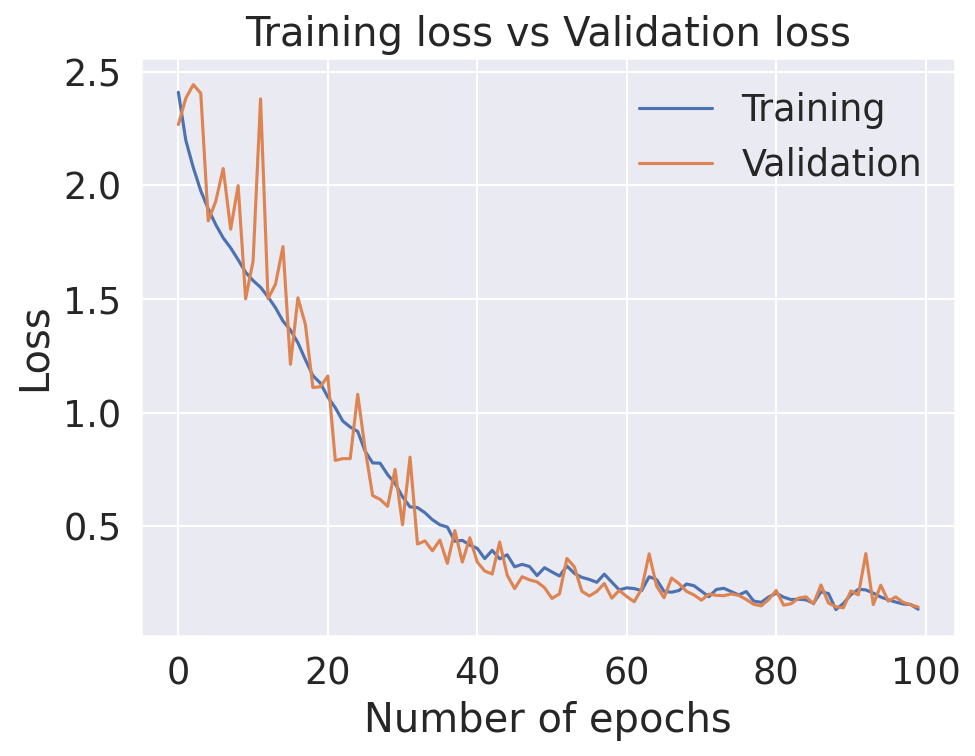

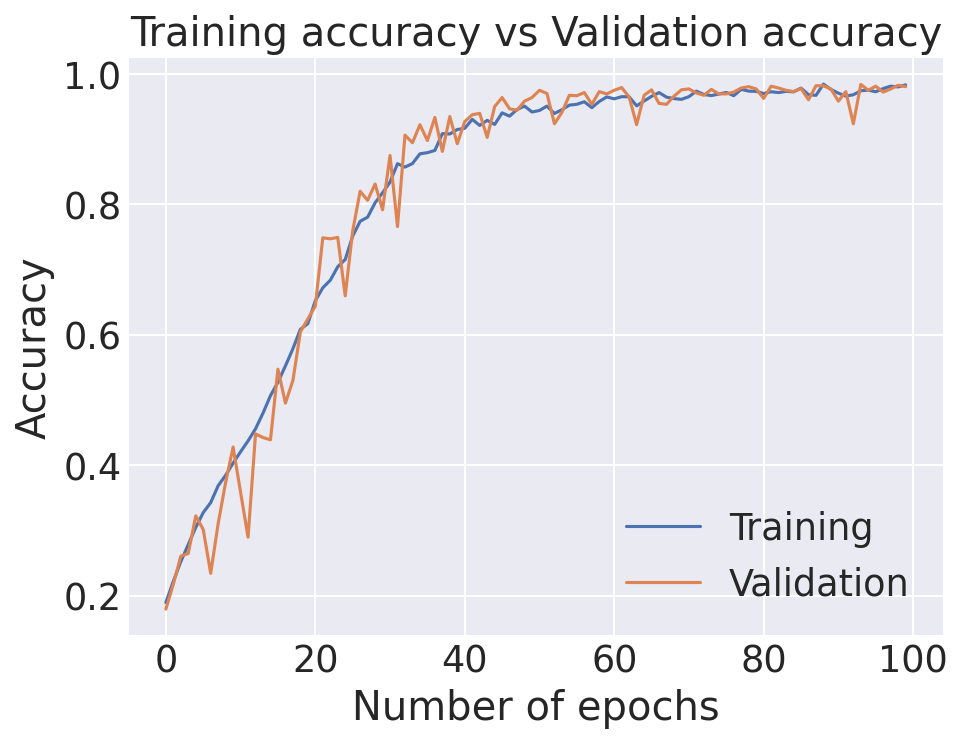

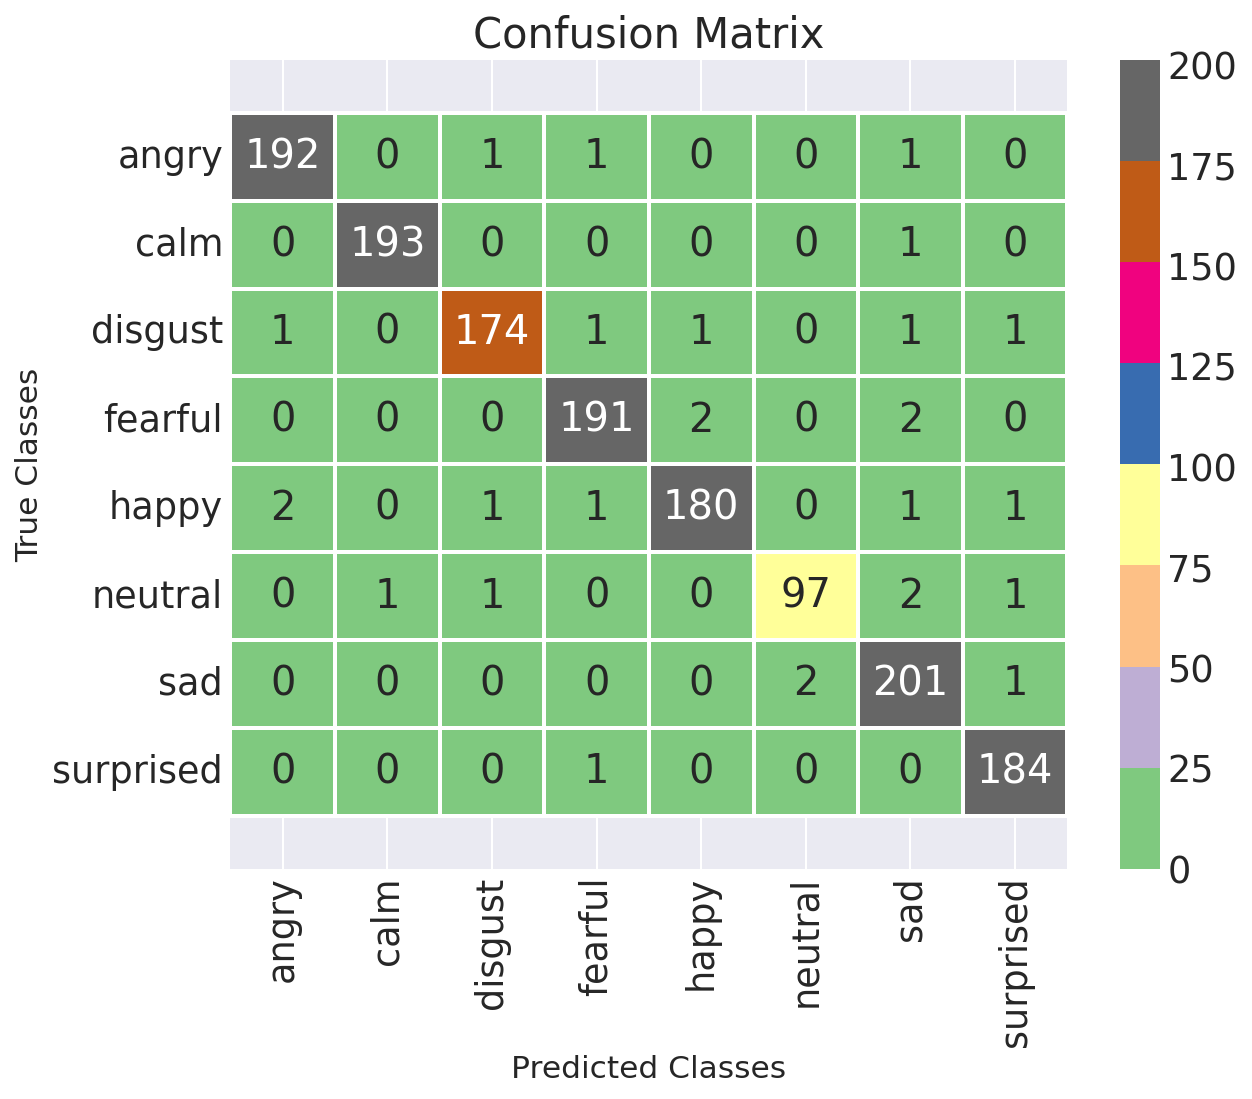

              precision    recall  f1-score   support

       angry       0.98      0.98      0.98       195
        calm       0.99      0.99      0.99       194
     disgust       0.98      0.97      0.98       179
        fear       0.98      0.98      0.98       195
       happy       0.98      0.97      0.98       186
     neutral       0.98      0.95      0.97       102
         sad       0.96      0.99      0.97       204
    surprise       0.98      0.99      0.99       185

    accuracy                           0.98      1440
   macro avg       0.98      0.98      0.98      1440
weighted avg       0.98      0.98      0.98      1440



In [37]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy'] 
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model1.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model1.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model1.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('ravdess-model1.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

In [38]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model2 = tf.keras.Sequential()
  model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
  model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
  model2.add(layers.MaxPooling1D(pool_size=(2)))
  model2.add(BatchNormalization())
  model2.add(layers.Dropout(0.2))
  model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model2.add(layers.MaxPooling1D(pool_size=(2)))
  model2.add(BatchNormalization())
  model2.add(layers.Dropout(0.2))
  model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model2.add(layers.MaxPooling1D(pool_size=(2)))
  model2.add(BatchNormalization())
  model2.add(layers.Dropout(0.25))
  model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model2.add(layers.MaxPooling1D(pool_size=(2)))
  model2.add(BatchNormalization())
  model2.add(layers.Dropout(0.25))
  model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model2.add(layers.MaxPooling1D(pool_size=(2)))
  model2.add(BatchNormalization())
  model2.add(layers.Dropout(0.5))
  model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model2.add(layers.MaxPooling1D(pool_size=(2)))
  model2.add(BatchNormalization())
  model2.add(layers.Dropout(0.25))
  model2.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model2.add(layers.MaxPooling1D(pool_size=(2)))
  model2.add(BatchNormalization())
  model2.add(layers.Dropout(0.25))
  model2.add(layers.LSTM(512))
  model2.add(layers.Dropout(0.5))
  model2.add(layers.Flatten())
  model2.add(layers.Dropout(0.5))
  model2.add(layers.Dense(128, activation='relu'))
  model2.add(layers.Dropout(0.5))
  model2.add(layers.Dense(64, activation='relu'))
  model2.add(layers.Dropout(0.5))
  model2.add(layers.Dense(8, activation='softmax'))
  model2.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model2.summary()
  model2.save('English_CNN/model2-CNN-RAVDESS-4.weights.h5')
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',   save_weights_only=True)
  model_history=model2.fit(inputs[train], targets[train],batch_size=32, epochs=100, validation_data=(x_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model2.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_96 (Conv1D)              │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_97 (Conv1D)              │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_84 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_98 (Conv1D)              │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_85 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_99 (Conv1D)              │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_86 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_100 (Conv1D)             │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_87 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_101 (Conv1D)             │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_88 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_102 (Conv1D)             │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,230,600 (12.32 MB)

 Trainable params: 3,228,168 (12.31 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1598 - loss: 2.3017
Epoch 1: val_accuracy improved from -inf to 0.13542, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.1599 - loss: 2.3012 - val_accuracy: 0.1354 - val_loss: 2.4034
Epoch 2/100
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2492 - loss: 2.0510
Epoch 2: val_accuracy improved from 0.13542 to 0.25208, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2491 - loss: 2.0506 - val_accuracy: 0.2521 - val_loss: 1.9487
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2622 - loss: 1.9217
Epoch 3: val_accuracy did not improve from 0.25208
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2623 - loss: 1.9216 - val_accuracy: 0.2208 - val_loss: 2.5708
Epoch 4/100
169/169 ━━━━

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_104 (Conv1D)             │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_105 (Conv1D)             │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_91 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_106 (Conv1D)             │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_92 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_107 (Conv1D)             │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_93 (MaxPooling1D) │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_108 (Conv1D)             │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_94 (MaxPooling1D) │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_109 (Conv1D)             │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_95 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_110 (Conv1D)             │ (None, 4, 256)         │       262,400 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,230,600 (12.32 MB)

 Trainable params: 3,228,168 (12.31 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1562 - loss: 2.3006
Epoch 1: val_accuracy improved from -inf to 0.13542, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.1567 - loss: 2.2994 - val_accuracy: 0.1354 - val_loss: 2.4919
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2375 - loss: 2.0416
Epoch 2: val_accuracy improved from 0.13542 to 0.20069, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2375 - loss: 2.0414 - val_accuracy: 0.2007 - val_loss: 2.2653
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2462 - loss: 1.9485
Epoch 3: val_accuracy improved from 0.20069 to 0.21806, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2463 - loss: 1.9483 - val_accur

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_112 (Conv1D)             │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_113 (Conv1D)             │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_98 (MaxPooling1D) │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_114 (Conv1D)             │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_99 (MaxPooling1D) │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_115 (Conv1D)             │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_100               │ (None, 18, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_116 (Conv1D)             │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_101               │ (None, 9, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_117 (Conv1D)             │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_102               │ (None, 4, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 4, 128)         │             

 Total params: 3,230,600 (12.32 MB)

 Trainable params: 3,228,168 (12.31 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1702 - loss: 2.2906
Epoch 1: val_accuracy improved from -inf to 0.19861, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.1706 - loss: 2.2896 - val_accuracy: 0.1986 - val_loss: 2.1170
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2455 - loss: 2.0495
Epoch 2: val_accuracy improved from 0.19861 to 0.24028, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2455 - loss: 2.0493 - val_accuracy: 0.2403 - val_loss: 2.0000
Epoch 3/100
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2570 - loss: 1.9382
Epoch 3: val_accuracy improved from 0.24028 to 0.27778, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2572 - loss: 1.9377 - val_accur

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_120 (Conv1D)             │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_121 (Conv1D)             │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_105               │ (None, 74, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_122 (Conv1D)             │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_106               │ (None, 37, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_123 (Conv1D)             │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_107               │ (None, 18, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_124 (Conv1D)             │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_108               │ (None, 9, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_125 (Conv1D)             │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_109               │ (None, 4, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,230,600 (12.32 MB)

 Trainable params: 3,228,168 (12.31 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1577 - loss: 2.3114
Epoch 1: val_accuracy improved from -inf to 0.21806, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.1581 - loss: 2.3101 - val_accuracy: 0.2181 - val_loss: 2.0785
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2405 - loss: 2.0603
Epoch 2: val_accuracy did not improve from 0.21806
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2405 - loss: 2.0601 - val_accuracy: 0.1333 - val_loss: 2.1165
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2470 - loss: 1.9448
Epoch 3: val_accuracy improved from 0.21806 to 0.22153, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2471 - loss: 1.9446 - val_accuracy: 0.2215 - val_loss: 1.9883
Epoch 4/100
167/169 ━━━━

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9759 - loss: 0.1954
Loss of the model is -  0.22183650732040405
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9759 - loss: 0.1954
Accuracy of the model is -  97.36111164093018 %
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


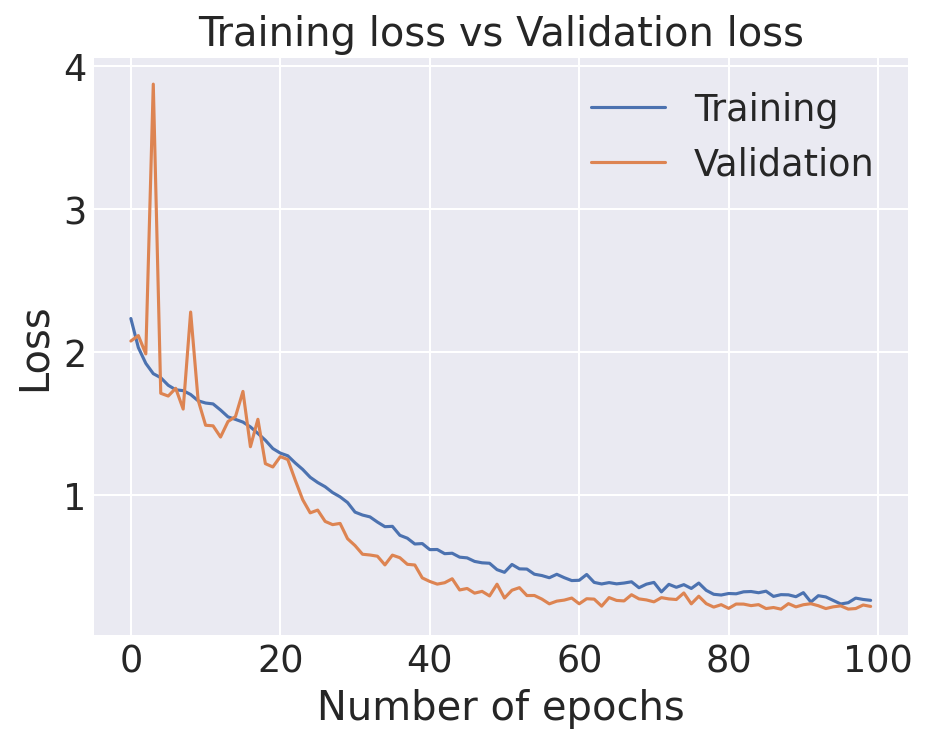

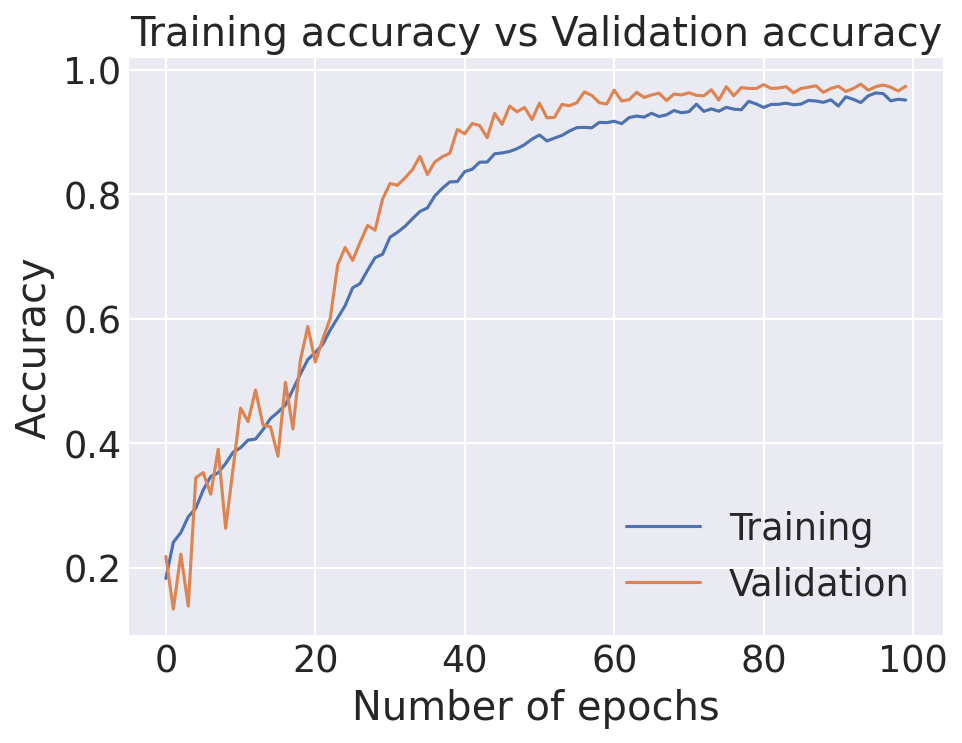

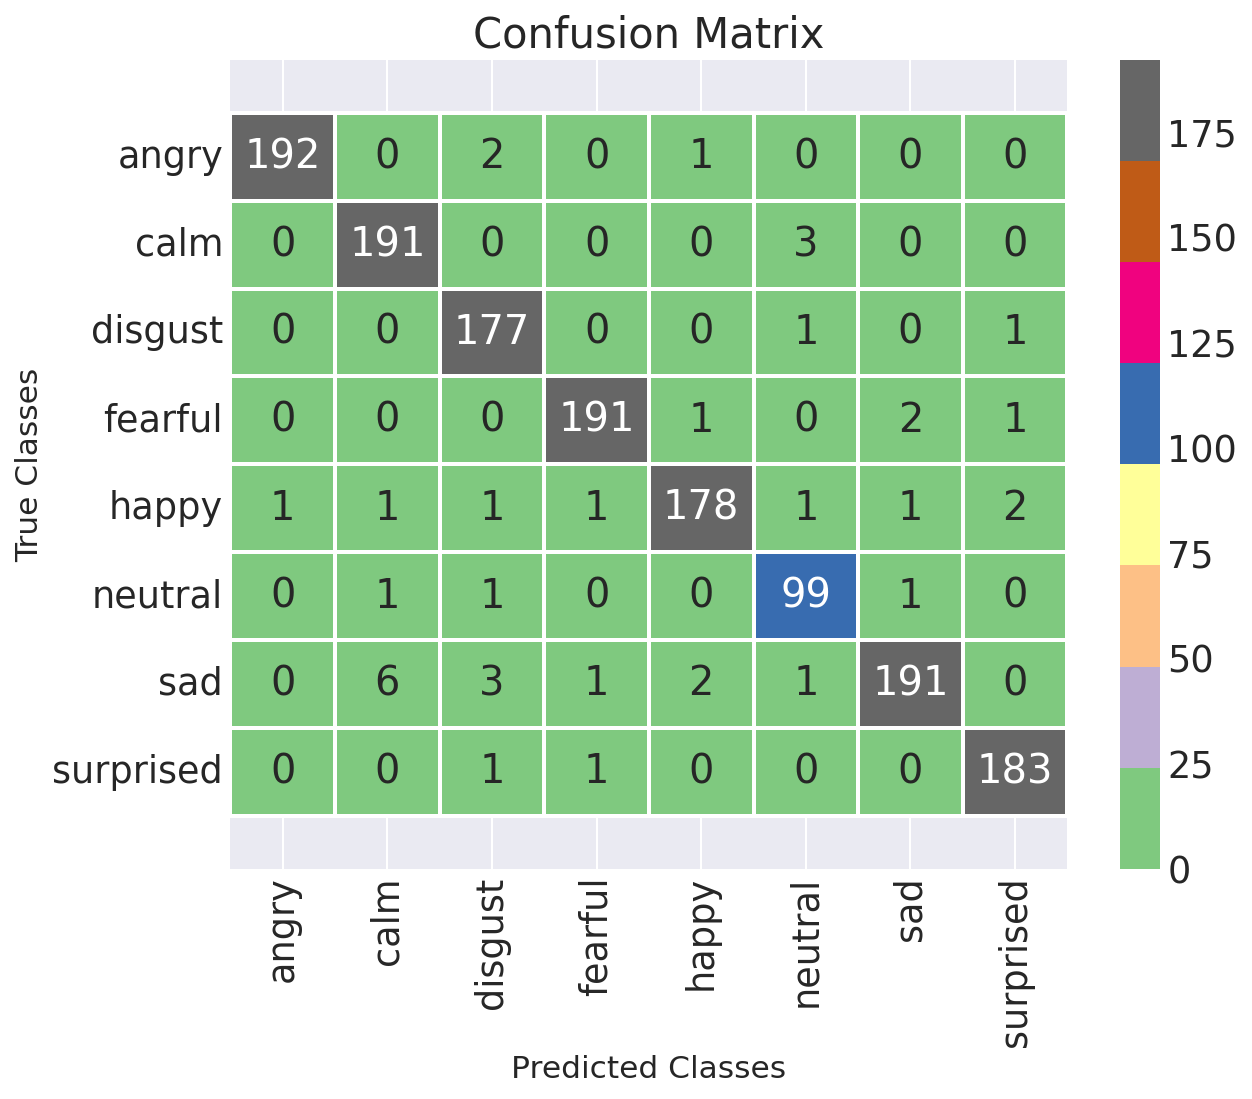

              precision    recall  f1-score   support

       angry       0.99      0.98      0.99       195
        calm       0.96      0.98      0.97       194
     disgust       0.96      0.99      0.97       179
        fear       0.98      0.98      0.98       195
       happy       0.98      0.96      0.97       186
     neutral       0.94      0.97      0.96       102
         sad       0.98      0.94      0.96       204
    surprise       0.98      0.99      0.98       185

    accuracy                           0.97      1440
   macro avg       0.97      0.97      0.97      1440
weighted avg       0.97      0.97      0.97      1440



In [39]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy'] 
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model2.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('ravdess-model1.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

In [40]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model3 = tf.keras.Sequential()
  model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
  model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model3.add(layers.MaxPooling1D(pool_size=(2)))
  model3.add(BatchNormalization())
  model3.add(layers.Dropout(0.35))
  model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model3.add(layers.MaxPooling1D(pool_size=(2)))
  model3.add(BatchNormalization())
  model3.add(layers.Dropout(0.35))
  model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model3.add(layers.MaxPooling1D(pool_size=(2)))
  model3.add(BatchNormalization())
  model3.add(layers.Dropout(0.35))
  model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model3.add(layers.MaxPooling1D(pool_size=(2)))
  model3.add(BatchNormalization())
  model3.add(layers.Dropout(0.35))
  model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model3.add(layers.MaxPooling1D(pool_size=(2)))
  model3.add(BatchNormalization())
  model3.add(layers.Dropout(0.5))
  model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model3.add(layers.MaxPooling1D(pool_size=(2)))
  model3.add(BatchNormalization())
  model3.add(layers.Dropout(0.25))
  model3.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model3.add(layers.MaxPooling1D(pool_size=(2)))
  model3.add(BatchNormalization())
  model3.add(layers.Dropout(0.25))
  model3.add(layers.GRU(512))
  model3.add(layers.Flatten())
  model3.add(layers.Dropout(0.5))
  model3.add(layers.Dense(128, activation='relu'))
  model3.add(layers.Dropout(0.5))
  model3.add(layers.Dense(64, activation='relu'))
  model3.add(layers.Dense(8, activation='softmax'))
  model3.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model3.summary()
  model3.save('English_CNN/model3-CNN-RAVDESS-4.weights.h5')
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',   save_weights_only=True)
  model_history=model3.fit(inputs[train], targets[train],batch_size=32, epochs=100, validation_data=(x_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model3.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model3.metrics_names[0]} of {scores[0]}; {model3.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_128 (Conv1D)             │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_129 (Conv1D)             │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_112               │ (None, 74, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_130 (Conv1D)             │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_113               │ (None, 37, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_131 (Conv1D)             │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_114               │ (None, 18, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_132 (Conv1D)             │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_115               │ (None, 9, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_133 (Conv1D)             │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_116               │ (None, 4, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 2,936,712 (11.20 MB)

 Trainable params: 2,934,280 (11.19 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1829 - loss: 3.7302
Epoch 1: val_accuracy improved from -inf to 0.18542, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.1835 - loss: 3.7162 - val_accuracy: 0.1854 - val_loss: 2.3191
Epoch 2/100
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2420 - loss: 1.9392
Epoch 2: val_accuracy improved from 0.18542 to 0.20694, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2423 - loss: 1.9384 - val_accuracy: 0.2069 - val_loss: 2.4723
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2749 - loss: 1.8463
Epoch 3: val_accuracy improved from 0.20694 to 0.23056, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2750 - loss: 1.8463 - val_accur

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_136 (Conv1D)             │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_137 (Conv1D)             │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_119               │ (None, 74, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_138 (Conv1D)             │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_120               │ (None, 37, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_139 (Conv1D)             │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_121               │ (None, 18, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_140 (Conv1D)             │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_122               │ (None, 9, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_141 (Conv1D)             │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_123               │ (None, 4, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 2,936,712 (11.20 MB)

 Trainable params: 2,934,280 (11.19 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1753 - loss: 3.7401
Epoch 1: val_accuracy improved from -inf to 0.19097, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.1761 - loss: 3.7263 - val_accuracy: 0.1910 - val_loss: 2.2715
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2513 - loss: 1.9519
Epoch 2: val_accuracy improved from 0.19097 to 0.19375, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2514 - loss: 1.9517 - val_accuracy: 0.1937 - val_loss: 2.4572
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2884 - loss: 1.8497
Epoch 3: val_accuracy improved from 0.19375 to 0.28056, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2884 - loss: 1.8496 - val_accur

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_144 (Conv1D)             │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_145 (Conv1D)             │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_126               │ (None, 74, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_126         │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_146 (Conv1D)             │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_127               │ (None, 37, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_127         │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_147 (Conv1D)             │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_128               │ (None, 18, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_128         │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_148 (Conv1D)             │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_129               │ (None, 9, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_129         │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_149 (Conv1D)             │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_130               │ (None, 4, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_130         │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 2,936,712 (11.20 MB)

 Trainable params: 2,934,280 (11.19 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1782 - loss: 3.7348
Epoch 1: val_accuracy improved from -inf to 0.15000, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.1788 - loss: 3.7210 - val_accuracy: 0.1500 - val_loss: 2.1401
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2461 - loss: 1.9417
Epoch 2: val_accuracy did not improve from 0.15000
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2462 - loss: 1.9414 - val_accuracy: 0.1063 - val_loss: 2.1669
Epoch 3/100
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2755 - loss: 1.8544
Epoch 3: val_accuracy improved from 0.15000 to 0.23889, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2756 - loss: 1.8542 - val_accuracy: 0.2389 - val_loss: 2.4156
Epoch 4/100
169/169 ━━━━

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_152 (Conv1D)             │ (None, 155, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_153 (Conv1D)             │ (None, 148, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_133               │ (None, 74, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_133         │ (None, 74, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 74, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_154 (Conv1D)             │ (None, 74, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_134               │ (None, 37, 256)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_134         │ (None, 37, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_155 (Conv1D)             │ (None, 37, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_135               │ (None, 18, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_135         │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_156 (Conv1D)             │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_136               │ (None, 9, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_157 (Conv1D)             │ (None, 9, 128)         │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_137               │ (None, 4, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 2,936,712 (11.20 MB)

 Trainable params: 2,934,280 (11.19 MB)

 Non-trainable params: 2,432 (9.50 KB)

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1926 - loss: 3.6895
Epoch 1: val_accuracy improved from -inf to 0.17778, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.1928 - loss: 3.6804 - val_accuracy: 0.1778 - val_loss: 2.3505
Epoch 2/100
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2739 - loss: 1.9093
Epoch 2: val_accuracy did not improve from 0.17778
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2739 - loss: 1.9091 - val_accuracy: 0.1688 - val_loss: 2.6456
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2787 - loss: 1.8434
Epoch 3: val_accuracy improved from 0.17778 to 0.21042, saving model to SER_best_initial_model.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2787 - loss: 1.8433 - val_accuracy: 0.2104 - val_loss: 2.9773
Epoch 4/100
169/169 ━━━━

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9452 - loss: 0.2873
Loss of the model is -  0.2846170961856842
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9452 - loss: 0.2873
Accuracy of the model is -  94.30555701255798 %
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


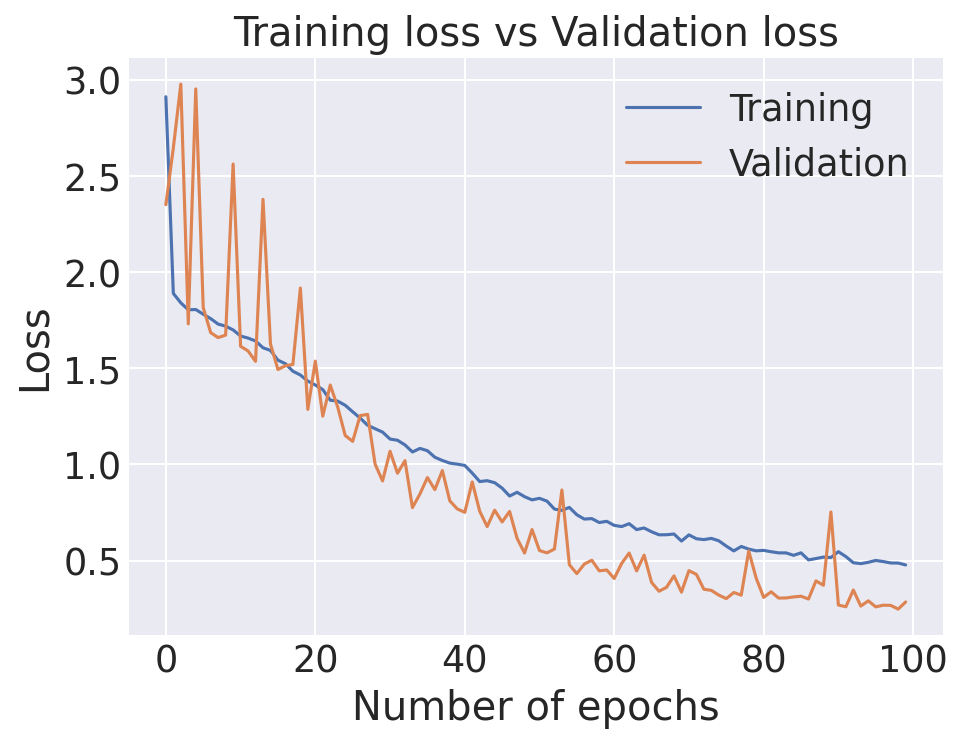

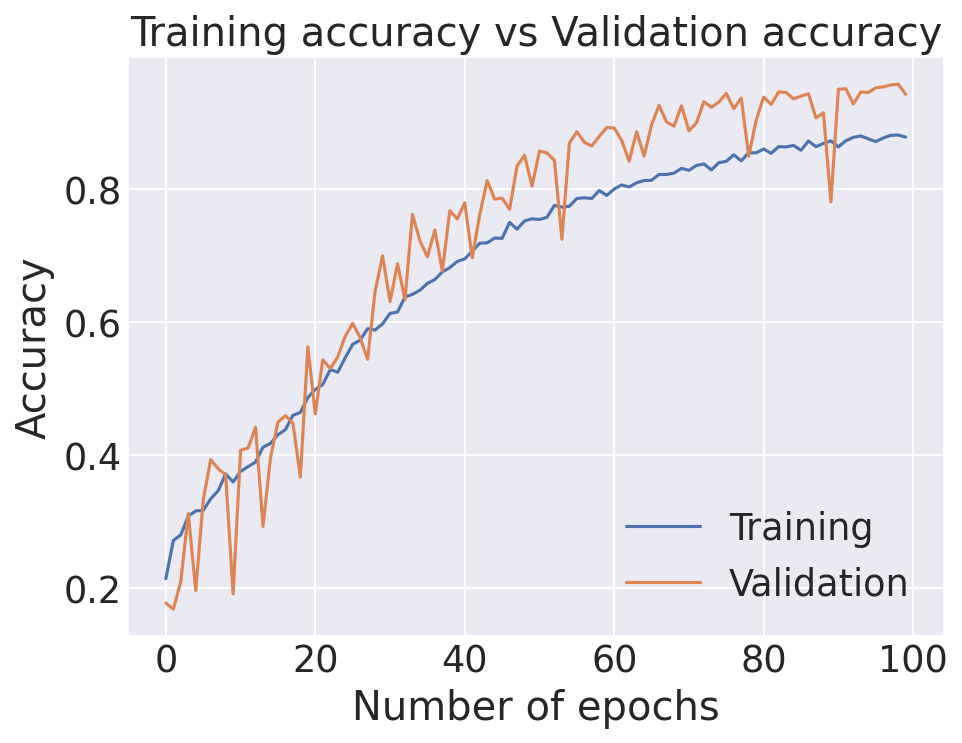

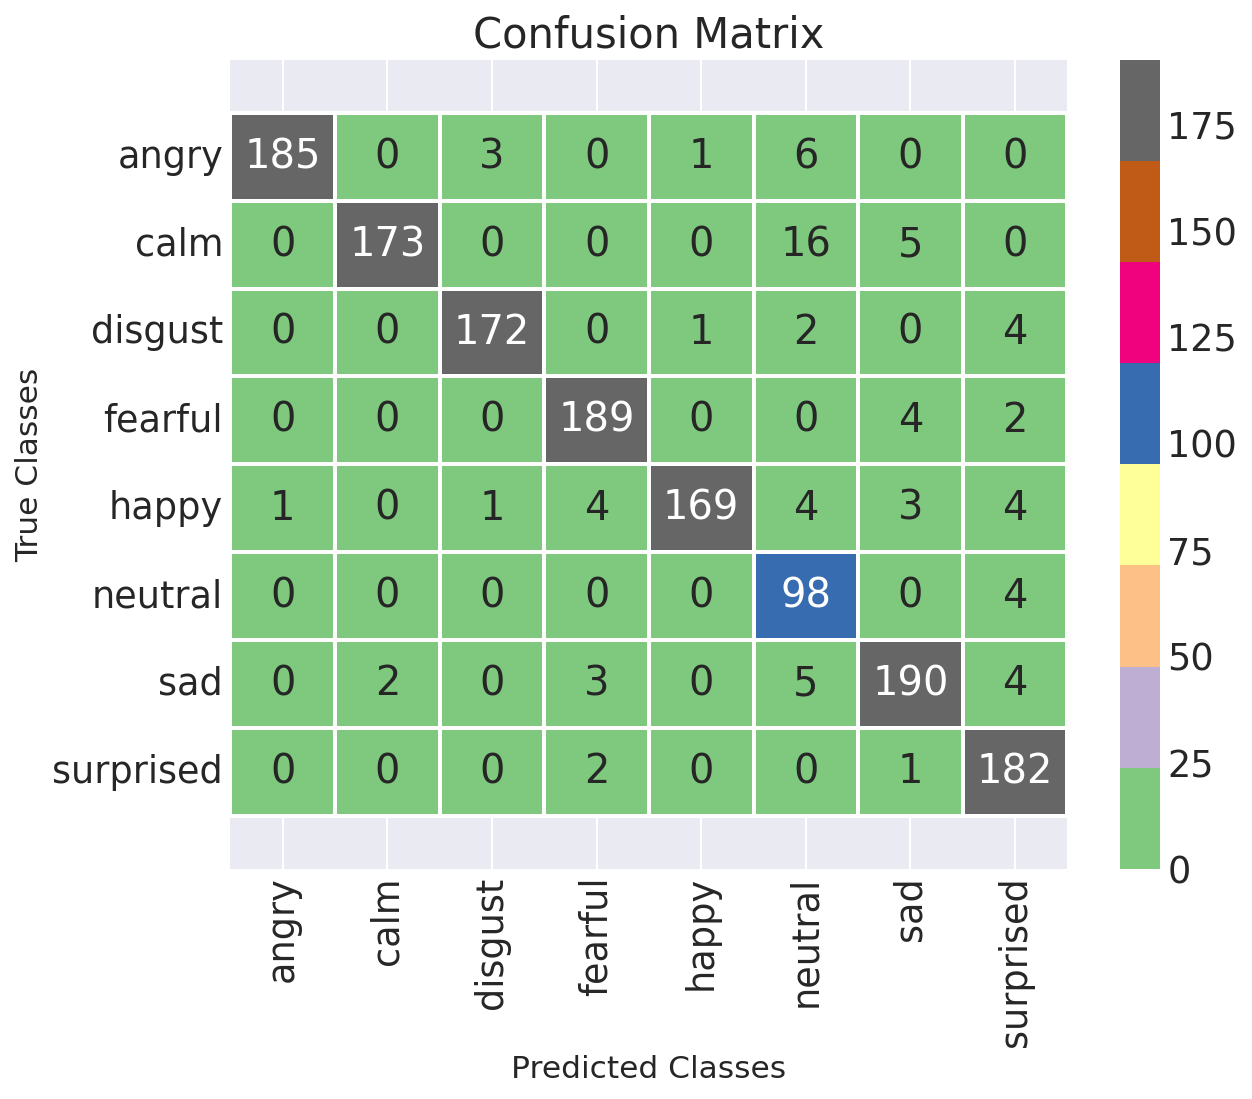

              precision    recall  f1-score   support

       angry       0.99      0.95      0.97       195
        calm       0.99      0.89      0.94       194
     disgust       0.98      0.96      0.97       179
        fear       0.95      0.97      0.96       195
       happy       0.99      0.91      0.95       186
     neutral       0.75      0.96      0.84       102
         sad       0.94      0.93      0.93       204
    surprise       0.91      0.98      0.95       185

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.95      0.94      0.94      1440



In [41]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy'] 
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model3.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model3.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model3.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('ravdess-model1.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise']))

In [42]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.136.0
    Uninstalling google-api-python-client-2.136.0:
      Successfully uninstalled google-api-python-client-2.136.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.137.0 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [43]:
from googleapiclient.discovery import build
from google.oauth2 import service_account
import os 
from googleapiclient.http import MediaFileUpload


SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = '/kaggle/input/service-account/service_account.json'
PARENT_FOLDER_ID = "1-2ApPZEi4FA3fyd487CP1blLFjLac8eN"

def authenticate():
    creds = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE,scopes=SCOPES)
    return creds

def upload_file(file_path):
    creds = authenticate()
    service = build('drive', 'v3', credentials=creds)

    # Check if the path is a directory
    if os.path.isdir(file_path):
        # If it's a directory, create a folder in Google Drive
        file_metadata = {
            'name': os.path.basename(file_path), # Use the folder name
            'mimeType': 'application/vnd.google-apps.folder', # Specify folder type
            'parents': [PARENT_FOLDER_ID]
        }

        folder = service.files().create(body=file_metadata, fields='id').execute()
        folder_id = folder.get('id')

        # Upload files within the directory
        for item in os.listdir(file_path):
            item_path = os.path.join(file_path, item)
            if os.path.isfile(item_path):
                upload_file_to_folder(service, item_path, folder_id) # Call a helper function to upload individual files
    else:
        # If it's a file, upload it directly
        file_metadata = {
            'name': os.path.basename(file_path),
            'parents': [PARENT_FOLDER_ID]
        }

        media = MediaFileUpload(file_path, resumable=True) # Use MediaFileUpload for file uploads
        file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()
    print("Folder uploaded successfully!")

def upload_file_to_folder(service, file_path, folder_id):
    """Helper function to upload a file to a specific folder."""
    file_metadata = {
        'name': os.path.basename(file_path),
        'parents': [folder_id]
    }

    media = MediaFileUpload(file_path, resumable=True)
    file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()

    
upload_file("saved_models")
upload_file("English_CNN")

Folder uploaded successfully!
Folder uploaded successfully!
